# Logistic Regression, Pandas, and TensorFlow

Here, we will use the extremely powerful TensorFlow library for Machine Learning (ML) from Google. We will also learn how to use the versatile Pandas package for handling data. For those of you familiar with the R language, the Pandas objects are extremely similar to the dataframe objects in R. We will work with a SUSY dataset available from the UC-Irvine ML Repository. 

Description of the dataset:

The data has been produced using Monte Carlo simulations and contains events with two leptons (electrons or muons). In high energy physics experiments, such as the ATLAS and CMS detectors at the CERN LHC, one major hope is the discovery of new particles. To accomplish this task, physicists attempt to sift through data events and classify them as either a signal of some new physics process or particle, or instead a background event from understood Standard Model processes. Unfortunately we will never know for sure what underlying physical process happened (the only information to which we have access are the final state particles). However, we can attempt to define parts of phase space that will have a high percentage of signal events. Typically this is done by using a series of simple requirements on the kinematic quantities of the final state particles, for example having one or more leptons with large amounts of momentum that is transverse to the beam line ($p_T$). Here instead we will use logistic regression in order to attempt to find out the relative probability that an event is from a signal or a background event and rather than using the kinematic quantities of final state particles directly we will use the output of our logistic regression to define a part of phase space that is enriched in signal events. The dataset we are using has the value of 18 kinematic variables ("features") of the event. The first 8 features are direct measurements of final state particles, in this case the $p_T$, pseudo-rapidity ($\eta$), and azimuthal angle ($\phi$) of two leptons in the event and the amount of missing transverse momentum (MET) together with its azimuthal angle. The last ten features are functions of the first 8 features; these are high-level features derived by physicists to help discriminate between the two classes. You can think of them as physicists attempt to use non-linear functions to classify signal and background events and they have been developed with a lot of deep thinking on the part of physicist. There is however, an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks and the dropout algorithm are presented in the original paper to compare the ability of deep-learning to bypass the need of using such high level features. We will also explore this topic in later notebooks. The dataset consists of 5 million events, the first 4,500,000 of which we will use for training the model and the last 500,000 examples will be used as a test set.

This dataset comes from this interesting paper by the UCI group: P. Baldi, P. Sadowski, and D. Whiteson. "Searching for Exotic Particles in High-energy Physics with Deep Learning." Nature Communications 5 (July 2, 2014).

### Classification task

During supervised learning tasks in linear regression, the goal is to make predictions about continuous labels. This task is different, we are interested in assigning samples to categories. The training data consists of a set of features and discrete labels. This type of data is called categorical data (the data comes in different categories).

Here, we will focus on a binary classification task. In the SUSY dataset, the goal is to decide whether a data point represents signal "potential collision"- labeled 1, or "background"(Standard Model processes which produce final states with similar constituents as SUSY processes) - labeled 0. This is done by looking at 18 features - the first 8 of which are "low-level" features that can be directly measured and the last 10 features are "higher-order" features constructed using physics intuition. In more detail:

The first column is the class label (1 for signal, 0 for background), followed by the 18 features (8 low-level features then 10 high-level features):: lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)

In this notebook we will use either the first 8 features or the full 18 features to predict whether an event is signal or background.

### Logistic regression

Logistic Regression is one of the best understood and canonical methods for performing the classification task. It is also the first step towards understanding modern Machine Learning. 

## Importing the data

First, we use pandas to import 4,500,000 events as training data and another 500,000 as test data. We are also using the tensorflow library and you might have to install it on your machine.

In [2]:
# Importing the SUSY Data set
import sys, os
import pandas as pd

import numpy as np
import warnings
#Commnet the next line on to turn off warnings
#warnings.filterwarnings('ignore')

seed=12
np.random.seed(seed)
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
x = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# suppress tflow compilation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

tf.set_random_seed(seed)

# Download the SUSY.csv (about 2GB) from UCI ML archive 
# and save it in the same directory as this jupyter notebook
# See: https://archive.ics.uci.edu/ml/machine-learning-databases/00279/
#filename="SUSY.csv"

filename=os.getcwd()+'/SUSY.csv' 

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

# Load 1,500,000 rows as train data, 50,000 as test data
df_train=pd.read_csv(filename,names=columns,nrows=1500000,engine='python')
df_test=pd.read_csv(filename,names=columns,nrows=50000, skiprows=1500000,engine='python')


### MLE estimate

The Maximum-Likelihood Estimation (MLE) is the same as minimizing the cross-entropy. There is no closed form (analytic) expression for this. One way to find it is with gradient-descent like approaches: start with an arbitrary $w$ and then update our estimate based on our error function. In particular, we would like to nudge $w$ in the direction where the error is decreasing the fastest. Here we will use the Newton-Raphson method to calculate the gradient. 

### Logistic regression using TensorFlow

We will now run logistic regression on the SUSY dataset for the simple (8 parameters) and the full space. We will also explore ridge regression as a function of regularization parameter $\alpha$.

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
#import ml_style as style #optional styling sheet
#mpl.rcParams.update(style.style) #optional styling sheet

def getTrainData(nVar):
    designMatrix = df_train.iloc[:,1:nVar+1].values
    #now the signal
    labels = df_train['signal'].values # labels (0 or 1)
    return (designMatrix,labels)

def getTestData(nVar):
    designMatrix = df_test.iloc[:,1:nVar+1].values
    #now the signal
    labels = df_test['signal'].values
    return (designMatrix,labels)

# define
def build_roc_curve(probs, signal_bit, threshes):
    # Convert things to a pandas series to build a DataFrame
    # which will make ROC curve logic easier to express
    signal_probs = pd.Series(probs[:,1])
    signal_true = pd.Series(signal_bit)
    signal_df = pd.DataFrame(signal_probs, columns=['sig_prob'])
    signal_df.loc[:,'sig_true'] = signal_true
    Acceptance = []
    Rejection = []
    for thresh in threshes:
        # define acceptance
        signal_df.loc[:,'accept'] = signal_df['sig_prob'] > thresh
        # sum over data frame with slicing conditions
        nSigCor = len(signal_df[(signal_df['accept']) & (signal_df['sig_true']==1.)])
        nSig = len(signal_df[signal_df['sig_true']==1.])
        nBkgCor = len(signal_df[ (signal_df['sig_true']==0.) & (~signal_df['accept'])])
        nBkg = len(signal_df[signal_df['sig_true']==0.])
        Acceptance.append(nSigCor/nSig) # False positive rate
        Rejection.append(nBkgCor/nBkg) # True positive rate

    return Acceptance, Rejection

# let's define this as a function so we can call it easily
def runTensorFlowRegression(nVar,alpha):

    #make data array placeholder for just first 8 simple features
    x = tf.placeholder(tf.float32,[None,nVar])
    #make weights and bias
    W = tf.Variable(tf.zeros([nVar,2])) #we will make y 'onehot' 0 bit is bkg, 1 bit is signal
    b = tf.Variable(tf.zeros([2]))

    #make 'answer variable'
    y = tf.nn.softmax(tf.matmul(x, W) + b)
    #placeholder for correct answer
    y_ = tf.placeholder(tf.float32, [None, 2])
    #cross entropy with L2 regularizer
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y,labels=y_)+alpha*tf.nn.l2_loss(W))
    
    #define training step
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    #initialize variables 
    init = tf.global_variables_initializer()
    #setup session
    sess = tf.Session()
    sess.run(init)

    #ok now everything is setup for tensorflow, but we need the data in a useful form
    #first let's get the variables
    Var_train, Sig_train_bit1 = getTrainData(nVar)
    #now the signal
    Sig_train_bit0 = Sig_train_bit1.copy()
    Sig_train_bit0 = 1 - Sig_train_bit0
    Sig_train = np.column_stack((Sig_train_bit0,Sig_train_bit1))
    
    ######## ------- TRAINING ----------############
    #Now perform minibatch gradient descent with minibatches of size 100:
    n_data = len(Sig_train_bit1)
    minibatch_size = 1000
    n_minibatch = n_data//minibatch_size
    print('\t Training with %i minibatches, dataset size is %i'%(n_minibatch,n_data))
    for i in range(0, n_minibatch):
        sys.stdout.write("%.3f %% completed \r"%(100*i/n_minibatch))
        sys.stdout.flush()
        start = i*minibatch_size
        end = (i+1)*minibatch_size-1
        
        batch_x = Var_train[start:end]
        batch_y = Sig_train[start:end]
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y})
    
    
    # Accuracy function:
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    ######## ------- TESTING ----------############
    # Setup test data
    Var_test = df_test.iloc[:,1:nVar+1].values
    
    # Now the signal
    Sig_test_bit1 = df_test['signal'].values
    
    Sig_test_bit0 = Sig_test_bit1.copy()
    Sig_test_bit0 = 1 - Sig_test_bit0
    Sig_test = np.column_stack((Sig_test_bit0,Sig_test_bit1))
    print("\t Accuracy for alpha %.1E : %.3f" %(alpha,sess.run(accuracy, feed_dict={x: Var_test, y_: Sig_test})))
    
    # Get the weights
    weights = W.eval(session=sess)
    # Get probabilities assigned (i.e. evaluate y on test data)
    probs = y.eval(feed_dict = {x: Var_test}, session = sess)
    # now let's get the signal efficiency and background rejection on the test data
    print('\t Computing ROC curve ...')
    # build ROC curve by scanning over thresholds of probability of being
    # a background event and calculating signal efficiency/background rejection
    # at each threshold
    threshes = np.arange(0,1,0.01)
    Acceptance, Rejection = build_roc_curve(probs, Sig_test_bit1, threshes)

    return (probs,Acceptance,Rejection)

### Training on the first 8 variables

Training for alpha = 1.00E-10
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-10 : 0.770
	 Computing ROC curve ...
Training for alpha = 7.94E-10
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 7.9E-10 : 0.770
	 Computing ROC curve ...
Training for alpha = 6.31E-09
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 6.3E-09 : 0.770
	 Computing ROC curve ...
Training for alpha = 5.01E-08
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 5.0E-08 : 0.770
	 Computing ROC curve ...
Training for alpha = 3.98E-07
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 4.0E-07 : 0.770
	 Computing ROC curve ...
Training for alpha = 3.16E-06
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 3.2E-06 : 0.770
	 Computing ROC curve ...
Training for alpha = 2.51E-05
	 Training with 1500 minibatches, dataset size is 1500000
	 Accu

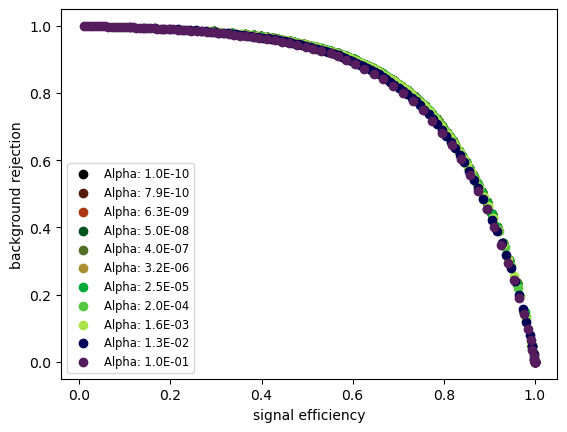

In [4]:
# This part might take some time on your machine
# We sweep the L2 regularizer strength (alpha) over 10 decades

alphas = np.logspace(-10,-1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    print("Training for alpha = %.2E"%alpha)
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probsSimple,accep,rej = runTensorFlowRegression(8,alpha)
    ax.scatter(accep,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1
    
ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

At this level we get an accuracy of 77%. This is a good result and it was obtained with only 8 variables. More important, this analysis with the ROC curve above allows physicists to define the parts of pahse space tha have more or less signal. Then, the individual analysts in particular searches will decide on the best working points for them.

Q1: How much improvement is due to the regularization used here? Explain what is happening and can you determine why?

We will now explore how mixed the events are.

	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-05 : 0.770
	 Computing ROC curve ...


<AxesSubplot:ylabel='Frequency'>

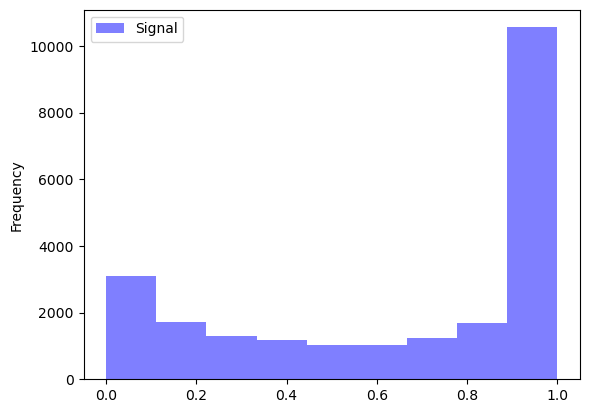

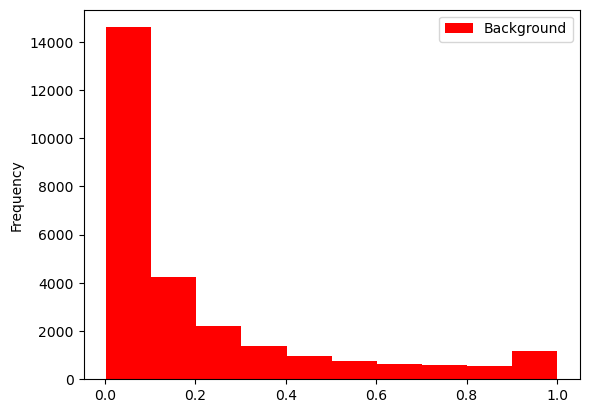

In [5]:
probsSimple,accep,rej = runTensorFlowRegression(8,.00001) # train the model for 8 variables and alpha=.00001
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Looking at the histograms, the classificator is pretty certain about its predictor. This is inferred from how the majority of the events are at the extremes of the probability. However, significant signal is loooking like background. This is what happens in HEP analysis. 

Q2: Modify and run the code above to do the same analysis but now with the 18 variables.

Q3: How does varying the regularization affect the results?

Q4: Since you increased from 8 kinematic variables to now 18 (added 10 more) did you find the increase in accuracy you expected? Explain what you expected and what you found. 